In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [39]:
# create engine to hawaii.sqlite
#engine = create_engine("sqlite+pysqlite:///SurfsUp/Resources/hawaii.sqlite")

engine = create_engine("sqlite+pysqlite:///" + r"C:\Users\sarit\OneDrive\Desktop\Class_Folder\mygithub\sqlalchemy-challenge\SurfsUp\Resources\hawaii.sqlite")


In [40]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.prepare(autoload_with=engine)

C:\Users\sarit\AppData\Local\Temp\ipykernel_22096\4155001391.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date


'2017-08-23'

In [106]:
# Calculate the date one year from the last date in data set.
twelve_months_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(months=12)
twelve_months_ago_date = twelve_months_ago.date()

In [107]:
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= twelve_months_ago_date).all()

In [154]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [109]:
# Sort the dataframe by date

precipitation_df_sorted = precipitation_df.sort_values(by='Date')

print(precipitation_df_sorted)

            Date  Precipitation
0     2016-08-23           0.00
1009  2016-08-23            NaN
1529  2016-08-23           1.79
704   2016-08-23           0.05
361   2016-08-23           0.15
...          ...            ...
1527  2017-08-22           0.00
1008  2017-08-23           0.00
360   2017-08-23           0.00
1528  2017-08-23           0.08
2229  2017-08-23           0.45

[2230 rows x 2 columns]


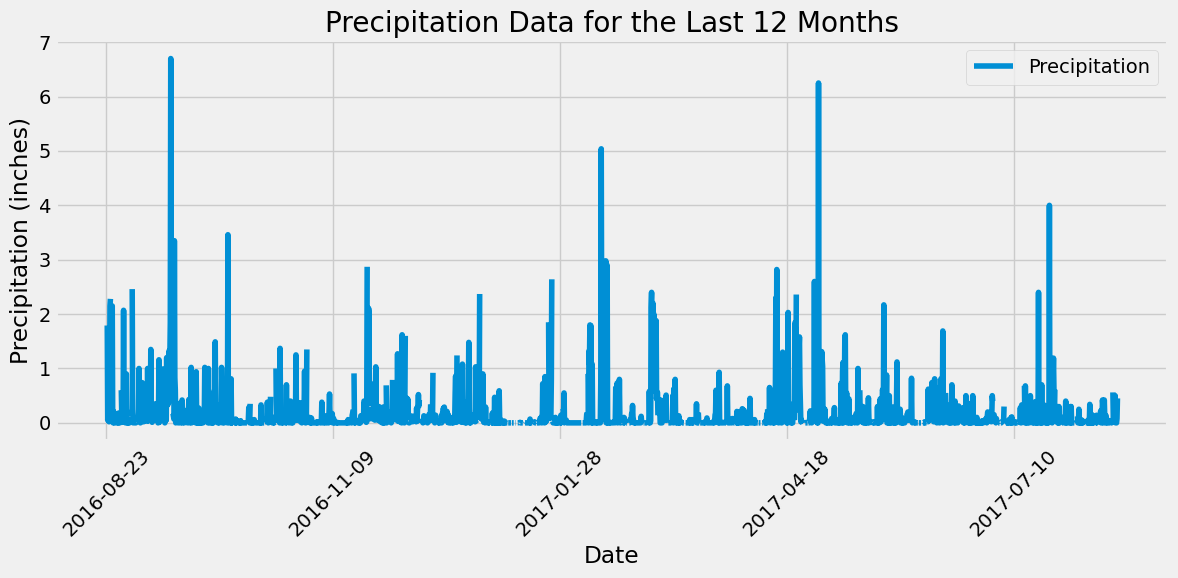

In [103]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df_sorted.plot(x='Date', y='Precipitation', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [112]:
# Use Pandas to calculate the summary statistics for the precipitation data
#summary_statistics= precipitation_df_sorted['Precipitation'].describe()
summary_statistics= precipitation_df_sorted.describe()
print(summary_statistics)


       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [153]:
df = pd.DataFrame(summary_statistics)
df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [81]:
from sqlalchemy import func

In [74]:
total_stations = session.query(func.count(func.distinct(Station.station))).all()
total_stations


[(9,)]

In [132]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

results = session.query(Station.station, Station.name, func.count(Measurement.id).label('num_rows')) \
                 .select_from(Station) \
                 .join(Measurement, Station.station== Measurement.station) \
                 .group_by(Station.station, Station.name) \
                 .order_by(func.count(Measurement.id).desc()) \
                 .all()

results_list = [(result.station, result.num_rows) for result in results]
results_list


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
most_active_station = results[0].station  # Get the most active station ID from the previous query results
most_active_station


'USC00519281'

In [151]:

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
       .filter(Measurement.station == most_active_station) \
       .all()

[(54.0, 85.0, 71.66378066378067)]

In [158]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
twelve_months_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(months=12)
twelve_months_ago_date = twelve_months_ago.date()

# Query the TOBS data for the specific station within the last 12 months
tobs_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= twelve_months_ago_date,
    Measurement.date <= most_recent_date
).all()

for row in tobs_data:
    print(row.date, row.tobs)


2016-08-23 77.0
2016-08-24 77.0
2016-08-25 80.0
2016-08-26 80.0
2016-08-27 75.0
2016-08-28 73.0
2016-08-29 78.0
2016-08-30 77.0
2016-08-31 78.0
2016-09-01 80.0
2016-09-02 80.0
2016-09-03 78.0
2016-09-04 78.0
2016-09-05 78.0
2016-09-06 73.0
2016-09-07 74.0
2016-09-08 80.0
2016-09-09 79.0
2016-09-10 77.0
2016-09-11 80.0
2016-09-12 76.0
2016-09-13 79.0
2016-09-14 75.0
2016-09-15 79.0
2016-09-16 78.0
2016-09-17 79.0
2016-09-18 78.0
2016-09-19 78.0
2016-09-20 76.0
2016-09-21 74.0
2016-09-22 77.0
2016-09-23 78.0
2016-09-24 79.0
2016-09-25 79.0
2016-09-26 77.0
2016-09-27 80.0
2016-09-28 78.0
2016-09-29 78.0
2016-09-30 78.0
2016-10-01 77.0
2016-10-02 79.0
2016-10-03 79.0
2016-10-04 79.0
2016-10-05 79.0
2016-10-06 75.0
2016-10-07 76.0
2016-10-08 73.0
2016-10-09 72.0
2016-10-10 71.0
2016-10-11 77.0
2016-10-12 79.0
2016-10-13 78.0
2016-10-14 79.0
2016-10-15 77.0
2016-10-16 79.0
2016-10-17 77.0
2016-10-18 78.0
2016-10-19 78.0
2016-10-20 78.0
2016-10-21 78.0
2016-10-22 77.0
2016-10-23 74.0
2016-10-

In [160]:
df = pd.DataFrame(tobs_data)
df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


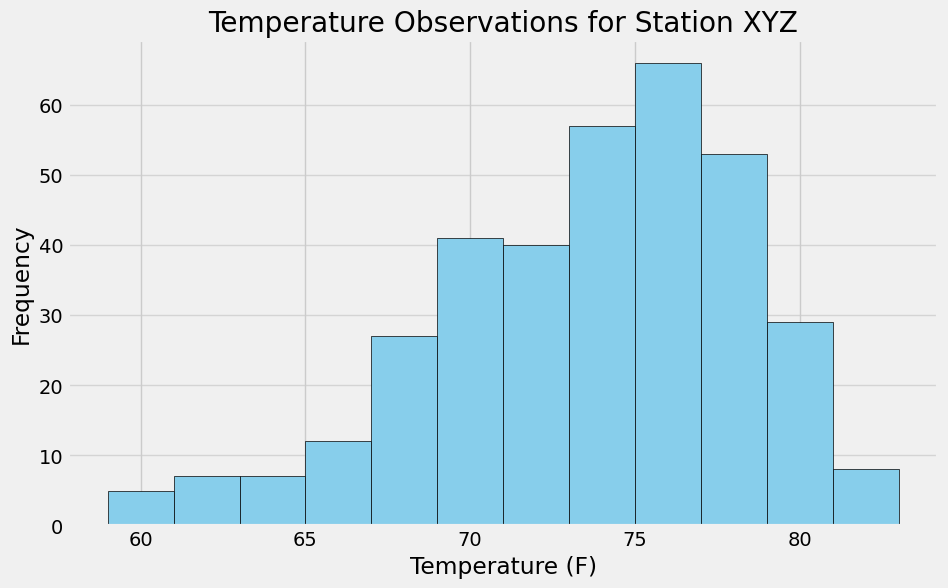

In [162]:
# Plot the histogram of temperature observations
plt.figure(figsize=(10, 6))
plt.hist(df['tobs'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station XYZ')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [163]:
# Close Session
session.close()